## <span style="color:#0066cc; font-weight:bold">INFERENCE PIPELINE FOR NEW TICKET CLASSIFICATION AND NEXT STEP RECOMMENDATION</span>

<p style="font-size:18px;">
This notebook orchestrates the total pipeline for a new ticket that is saved on PostgreSQL tickets table, using its ticket_id.<br> 
I am using some of the 128 tickets that I did not touch for any preprocessing, clustering or recommendations that I have marked with <strong>demo_flag = TRUE</strong>.
</p>


### <span style="color:#4da6ff; font-weight:bold">Demo setup

<p style="font-size:16px;">This setup involes cherry-picking at least 3 tickets( each represnting EN, SV, FI) from the "ticket" table where demo_flag = TRUE.
These tickets have not been preprocessed, embedded or previously seen by any models downstream.</p>

In [16]:
# Add project root to path 
import sys
from pathlib import Path
sys.path.append(str(Path("../").resolve()))

In [17]:
# Generic imports
import pandas as pd 


# imports from my project
import src.preprocessing_utils as prep
from src.db_utils import fetch_and_cleanup_tickets
import src.preprocessing_utils as prep
from src.db_utils import fetch_preprocessed_tickets, fetch_already_embedded_ticket_ids, insert_embeddings
from src.embedding_utils import batch_embed_and_store,embed_new_tickets
import src.recommendation_utils as ru
import src.diagnostic_utils as dgn


# Show full column content
pd.set_option('display.max_colwidth', None)

In [18]:
# Specify ticket_id for demo tickets

# English example : "TKT-524587"
# Finish example: "TKT-537091"
# Swedish example: "TKT-520235"
# Absurd ticket: "TKT-600000"

ticket_ids = ["TKT-524587", "TKT-537091", "TKT-520235", "TKT-600000" ]

In [19]:
# Now let's fetch the relevant records from the table "tickets".

new_tickets = fetch_and_cleanup_tickets(ticket_ids)
new_tickets

,ticket_id,created_at,channel,source_system,customer_name,subject,body,internal_comments,status,resolution_time_s,demo_flag,cluster_id,cluster_label,next_step,cluster_confidence,neighbour_confidence
0,TKT-520235,2025-06-12 11:46:22,portal,Portal,Sofia Heikkinen,Kan inte lägga till kort i Apple Pay,"Hallå, Hi, I'm Sofia Heikkinen. Jag har problem med tokenization/wallet. Täckningen borde räcka, så jag är förvirrad. IBAN: FI1801444981598892 Lansering imorgon, lite bråttom. Som jag nämnde tidigare, detta blockerar oss. Täckningen borde räcka, så jag är förvirrad. Täckningen borde räcka, så jag är förvirrad. Tack på förhand.","[[Agent-2] 2025-06-12 12:11 - Kontrollerade loggar; kod 05 för de senaste försöken., [Ops] 2025-06-12 12:20 - Väntar på dokument; påminnelse till imorgon., [TechOps] 2025-06-12 13:19 - Eskalering till TechOps; möjligt regionalt fel., [L2] 2025-06-12 15:08 - Eskalering till TechOps; möjligt regionalt fel., [L2] 2025-06-12 16:13 - Ingen incident på status-sidan; övervakning pågår.]",new,None,True,None,None,None,None,None
1,TKT-524587,2025-06-12 09:07:11,portal,Zendesk,Riley Salonen,How do I get a new card quickly? 😕,"Hi team, Hi, I'm Riley Salonen. My card keeps getting errors when I try to pay. Balance should be fine, so I'm confused. Balance should be fine, so I'm confused. We have a launch tomorrow, so it's a bit urgent. Best regards,","[[TechOps] 2025-06-12 10:13 - Checked auth logs; decline code 05 for last two attempts., [Agent-2] 2025-06-12 11:00 - No incident on status page; monitoring., [L2] 2025-06-12 12:24 - No incident on status page; monitoring.]",new,None,True,None,None,None,None,None
2,TKT-537091,2025-06-12 10:45:56,portal,EmailInbox,Ville Niemi,Miten kasvattaa API-kiintiötä? 😕,"Hi, I'm Ville Niemi. Ongelma liittyy aiheeseen: API Rate Limit/Auth. Testasin myös toisella laitteella. Phone: +46 427 235 2760 Email: ville.niemi@company.fi Ilmoittakaa jos tarvitsette kuvakaappauksia. Ilmoittakaa jos tarvitsette kuvakaappauksia.","[[Agent-1] 2025-06-12 11:46 - Tarkistettu lokit; viimeisissä yrityksissä koodi 05., [TechOps] 2025-06-12 13:16 - Ei häiriötä status-sivulla; seuranta käynnissä., [Agent-2] 2025-06-12 14:15 - Eskalointi TechOpsille; mahdollinen alueellinen vika.]",in_progress,None,True,None,None,None,None,None
3,TKT-600000,2025-10-16 11:31:57,email,EmailInbox,Antti Penttilä,My cat ate my card,"Hello, Hi, I'm Sam Gordens. My cat ate my credit card under the card number 4000 1234 5678 9010.",[],in_progress,None,True,None,None,None,None,None


### <span style="color:#4da6ff; font-weight:bold">Preprocessing tickets</span>

<p style="font-size:16px;">
In this section we will preprocess and write the results to the table <code>ticket_preprocessed</code>. There are 7 steps altogether:
</p>
<ol style="font-size:16px;">
    <li>Language detection with langdetect</li>
    <li>Text cleaning (removal of emojis and extra spacing)</li>
    <li>Translation to English using <code>Helsinki-NLP/opus-mt-sv-en</code> / <code>Helsinki-NLP/opus-mt-fi-en</code></li>
    <li>PII masking for names, locations, card numbers, telephone numbers, IBAN and email</li>
    <li>Combine cleaned and translated subject and body</li>
    <li>Keyword extraction from the above combination for verification purposes</li>
    <li>Write the preprocessed ticket data to PostgreSQL</li>
</ol>


In [20]:
preprocessed_tickets = prep.preprocess_tickets(new_tickets)

Cleaning & detecting language: 100%|█████████████| 4/4 [00:00<00:00, 226.10it/s]


[INFO] Translated batch 1 (1 texts) for language 'sv'
[INFO] Translated batch 1 (1 texts) for language 'sv'
[INFO] Translated 1 tickets from 'sv' to English
[INFO] Translated batch 1 (1 texts) for language 'fi'
[INFO] Translated batch 1 (1 texts) for language 'fi'
[INFO] Translated 1 tickets from 'fi' to English


Extracting keywords: 100%|██████████████████████| 4/4 [00:00<00:00, 20.81text/s]


[INFO] Keyword extraction completed for 4 texts
[INFO] DataFrame written to table 'ticket_preprocessed' successfully.
Preprocessed rows written to "ticket_preprocessed" table.


In [21]:
preprocessed_tickets

,ticket_id,lang,subject_clean,body_clean,subject_translated,body_translated,subject_masked,body_masked,combined_text,keywords
0,TKT-520235,sv,Kan inte lägga till kort i Apple Pay,"Hallå, Hi, I'm Sofia Heikkinen. Jag har problem med tokenization/wallet. Täckningen borde räcka, så jag är förvirrad. IBAN: FI1801444981598892 Lansering imorgon, lite bråttom. Som jag nämnde tidigare, detta blockerar oss. Täckningen borde räcka, så jag är förvirrad. Täckningen borde räcka, så jag är förvirrad. Tack på förhand.",Cannot add cards to Apple Pay,"Hello, Hi, I'm Sofia Heikkinen. I have problems with tokenization/wallet. Coverage should be enough, so I'm confused. IBAN: FI180444981598892 Launching tomorrow, a bit of a hurry. As I mentioned earlier, this is blocking us. Coverage should be enough, so I'm confused. Coverage should be enough, so I'm confused. Thank you in advance.",Cannot add cards to Apple Pay,"Hello, Hi, I'm [PERSON]. I have problems with tokenization/wallet. Coverage should be enough, so I'm confused. IBAN: [IBAN] Launching tomorrow, a bit of a hurry. As I mentioned earlier, this is blocking us. Coverage should be enough, so I'm confused. Coverage should be enough, so I'm confused. Thank you in advance.","Cannot add cards to Apple Pay || , , I'm [PERSON]. I have problems with tokenization/wallet. Coverage should be enough, so I'm confused. IBAN: [IBAN] Launching tomorrow, a bit of a hurry. As I mentioned earlier, this is blocking us. Coverage should be enough, so I'm confused. Coverage should be enough, so I'm confused. Thank you in advance.","[add cards apple pay, cards apple pay problems, apple pay problems tokenization, wallet coverage confused iban, cards apple pay, problems tokenization wallet coverage, tokenization wallet coverage confused, tokenization wallet coverage, add cards apple, apple pay problems]"
1,TKT-524587,en,How do I get a new card quickly?,"Hi team, Hi, I'm Riley Salonen. My card keeps getting errors when I try to pay. Balance should be fine, so I'm confused. Balance should be fine, so I'm confused. We have a launch tomorrow, so it's a bit urgent. Best regards,",How do I get a new card quickly?,"Hi team, Hi, I'm Riley Salonen. My card keeps getting errors when I try to pay. Balance should be fine, so I'm confused. Balance should be fine, so I'm confused. We have a launch tomorrow, so it's a bit urgent. Best regards,",How do I get a new card quickly?,"Hi team, Hi, I'm [PERSON]. My card keeps getting errors when I try to pay. Balance should be fine, so I'm confused. Balance should be fine, so I'm confused. We have a launch tomorrow, so it's a bit urgent. Best regards,","How do I get a new card quickly? || team, , I'm [PERSON]. My card keeps getting errors when I try to pay. Balance should be fine, so I'm confused. Balance should be fine, so I'm confused. We have a launch tomorrow, so it's a bit urgent. Best regards,","[new card quickly, new card, card keeps getting, card quickly, card keeps getting errors, try pay balance, card, errors try pay balance, new card quickly team, card quickly team card]"
2,TKT-537091,fi,Miten kasvattaa API-kiintiötä?,"Hi, I'm Ville Niemi. Ongelma liittyy aiheeseen: API Rate Limit/Auth. Testasin myös toisella laitteella. Phone: +46 427 235 2760 Email: ville.niemi@company.fi Ilmoittakaa jos tarvitsette kuvakaappauksia. Ilmoittakaa jos tarvitsette kuvakaappauksia.",How to increase the API quota?,"Hi, I'm Ville Niemi. The problem is related to API Rate Limit/Auth. I also tested with another device. Phone: +46 427 235 2760 Email: ville.niemi@company.fi Please let me know if you need screenshots.",How to increase the API quota?,"Hi, I'm [PERSON]. The problem is related to API Rate Limit/Auth. I also tested with another device. Phone: [PHONE] Email: [EMAIL] Please let me know if you need screenshots.","How to increase the API quota? || , I'm [PERSON]. The problem is related to API Rate Limit/Auth. I also tested with another device. Phone: [PHONE] Email: [EMAIL] Please let me know if 

### <span style="color:#4da6ff; font-weight:bold">Embedding combined_text (subject + body)</span>

<ul style="font-size:16px;">
    <li>Now I am going to embed the <code>combined_text</code> field from <code>tickets_preprocessed</code> table.</li>
    <li>This field is <code>{translated_subject || masked_body}</code> which I feel is sufficient to categorize issue types.</li>
    <li>The embeddings I use is <code>all-MiniLM-L6-v2</code> from SentenceTransformers which outputs a 384-dimensional vector.</li>
    <li>This vector will also be saved on the <code>ticket_embedding</code> table on PostgreSQL for later steps.</li>
</ul>

<p style="font-size:16px;"><strong>Note:</strong> The embedding model is configurable (change <code>src.configs.LOCAL_EMBEDDING_MODEL</code> and the vector size of the <code>embedding</code> column).</p>


In [22]:
embed_new_tickets()

[INFO] 4 tickets left to embed
Embedding 4 tickets (batch size 128)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Inserted embeddings for batch 0-3
Embeddings for 4 tickets added to "ticket_embeddings" table.


### <span style="color:#4da6ff; font-weight:bold">Using saved HDBSCAN model to predict a new ticket's category and next step recommendation </span>

<p style="font-size:16px;">
The output dimension of the embeddings (384) is too high for clustering, since distance measures become less meaningful and clustering itself scales poorly. 
I have used <strong>UMAP (Uniform Manifold Approximation and Projection)</strong> to project the embeddings into a reasonable dimension before clustering. 
This projector has been saved as a <code>.pkl</code> file so that any new tickets go through the exact same projector before being categorized by the clustering model.
</p>

<p style="font-size:16px;">
I have implemented a clusterer using <strong>HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise)</strong> because:
</p>
<ol style="font-size:16px;">
    <li>The number of clusters, their shapes, and densities are unknown.</li>
    <li>The dataset could be noisy and contain many outliers.</li>
</ol>

<p style="font-size:16px;">
The generated and saved clusterer should be loaded for this section. It will be used to categorize new tickets using <code>approximate_predict</code> in HDBSCAN. 
Note that even a new ticket with a previously unseen issue category will still fall into an existing cluster but with a <strong><span style="color:red;">very low confidence score. </span></strong>
</p>

<p style="font-size:16px;">
I maintain a <code>cluster_labels</code> table which has human-readable issue category names. 
A local LLM (<code>mistral:7b</code> via Ollama currently) is prompted to inspect the <code>combined_text</code> of the top-N (10 currently) tickets closest to each cluster center and issue a suitable natural language label. 
</p>

<p style="font-size:16px;">
After the issue categorization, the recommender program will:
</p>
<ol style="font-size:16px;">
    <li>Find the closest ticket in the same cluster.</li>
    <li>Prefer resolved/closed tickets; otherwise use the nearest open ticket.</li>
    <li>Compare <code>internal_comments</code> via an LLM (<code>mistral:7b</code> via Ollama currently) to suggest the next recommended step. 
    This could be knowledge from the neighbor or general advice depending on the neighbor_confidence (I am using > 0.8).</li>
</ol>

<p style="font-size:16px;"> <strong>Note:</strong> The local model can be configured via <code>src.ai_utils</code>.</p>


In [23]:
# Store results
results = []

# Get cluster id, label, and suggested next step for each ticket
for tid in ticket_ids:
    (
        suggestion,
        c_confidence,
        n_confidence,
        cluster_id,
        cluster_label,
        best_comments,
        nearest_ticket_id,
        nearest_ticket_status,
        internal_comments
    ) = ru.find_recommendation(tid)


    results.append({
        "ticket_id": tid,
        "Cluster ID": cluster_id,
        "Cluster Label": cluster_label,
        "Cluster confidence": round(c_confidence, 2),
        "Neighbour confidence": round(n_confidence, 2),
        "Nearest Ticket": nearest_ticket_id,
        "Nearest Ticket Status": nearest_ticket_status,
        "Neighbouring Action Sequence": best_comments,
        "Suggested Next Step": suggestion,
        "Internal Comments": internal_comments
    })

# Convert to DataFrame
df_results = pd.DataFrame(results)

# Join with preprocessed_tickets to add combined_text 
if 'ticket_id' not in preprocessed_tickets.columns:
    raise KeyError("`preprocessed_tickets` must contain a 'ticket_id' column for joining.")

# Select only needed columns to avoid duplication or bloat
df_joined = df_results.merge(
    preprocessed_tickets[["ticket_id", "combined_text"]],
    on="ticket_id",
    how="left"
)

# Define desired column order
column_order = [
    "ticket_id",
    "Cluster ID",
    "Cluster Label",
    "combined_text",
    "Cluster confidence",
    "Nearest Ticket",
    "Nearest Ticket Status",
    "Neighbouring Action Sequence",
    "Internal Comments",
    "Suggested Next Step",
    "Neighbour confidence"
]

# Reorder columns
df_joined = df_joined[column_order]

# Display final DataFrame
display(df_joined)





Table "tickets" updated with TKT-524587's cluster_id, cluster_label, suggestion and confidences.
Table "tickets" updated with TKT-537091's cluster_id, cluster_label, suggestion and confidences.
Table "tickets" updated with TKT-520235's cluster_id, cluster_label, suggestion and confidences.
Table "tickets" updated with TKT-600000's cluster_id, cluster_label, suggestion and confidences.


,ticket_id,Cluster ID,Cluster Label,combined_text,Cluster confidence,Nearest Ticket,Nearest Ticket Status,Neighbouring Action Sequence,Internal Comments,Suggested Next Step,Neighbour confidence
0,TKT-524587,33,Urgent Card Issue,"How do I get a new card quickly? || team, , I'm [PERSON]. My card keeps getting errors when I try to pay. Balance should be fine, so I'm confused. Balance should be fine, so I'm confused. We have a launch tomorrow, so it's a bit urgent. Best regards,",1.00,TKT-545894,closed,- Replied to customer; requested last 4 of PAN and timestamp. - Escalated to TechOps; possible regional issue. - Checked auth logs; decline code 05 for last two attempts. - Replied to customer; requested last 4 of PAN and timestamp.,- Checked auth logs; decline code 05 for last two attempts. - No incident on status page; monitoring. - No incident on status page; monitoring.,Escalate the issue to TechOps for further investigation due to repeated decline code 05.,0.96
1,TKT-537091,20,Increase API Quota Inquiry,"How to increase the API quota? || , I'm [PERSON]. The problem is related to API Rate Limit/Auth. I also tested with another device. Phone: [PHONE] Email: [EMAIL] Please let me know if you need screenshots.",1.00,TKT-536844,closed,- Eskalointi TechOpsille; mahdollinen alueellinen vika. - Ei häiriötä status-sivulla; seuranta käynnissä.,- Tarkistettu lokit; viimeisissä yrityksissä koodi 05. - Ei häiriötä status-sivulla; seuranta käynnissä. - Eskalointi TechOpsille; mahdollinen alueellinen vika.,Escalate the issue to TechOps team for potential local problem diagnosis.,0.97
2,TKT-520235,22,Tokenization/Apple Pay Issues,"Cannot add cards to Apple Pay || , , I'm [PERSON]. I have problems with tokenization/wallet. Coverage should be enough, so I'm confused. IBAN: [IBAN] Launching tomorrow, a bit of a hurry. As I mentioned earlier, this is blocking us. Coverage should be enough, so I'm confused. Coverage should be enough, so I'm confused. Thank you in advance.",0.53,TKT-543369,resolved,- Eskalering till TechOps; möjligt regionalt fel. - Svarade kunden; begärde sista 4 av kort och tidsstämpel.,- Kontrollerade loggar; kod 05 för de senaste försöken. - Väntar på dokument; påminnelse till imorgon. - Eskalering till TechOps; möjligt regionalt fel. - Eskalering till TechOps; möjligt regionalt fel. - Ingen incident på status-sidan; övervakning pågår.,Request TechOps to investigate potential regional issues and provide the customer with the last four digits of their card and a timestamp for further troubleshooting Apple Pay activation.,0.90
3,TKT-600000,68,Card Replacement Requests (Urgent),"My cat ate my card || , , I'm [PERSON]. My cat ate my credit card under the card number [CARD].",1.00,TKT-547462,closed,None,,Request customer to provide a photo of the damaged card and issue a replacement card as soon as possible.,0.64


### <span style="color:#4da6ff; font-weight:bold">Results validation</span>

<div style="font-size:16px;">
    <p>
        This section demonstrates some of the possible diagnostic tools to make sense of why results are the way they are.
    </p>
    <ul>
        <li><strong>Diagnostic step 1:</strong> Fetches the <code>subject_translated</code> and <code>body_translated</code> for a given ticket and its closest neighbour for manual comparison and verification by a domain expert.</li>
        <li><strong>Diagnostic step 2:</strong> Reduces the embedding dimension to 2D and visualises all clusters, highlighting a given ticket. </li>
        <li><strong>Diagnostic step 3:</strong> Reduces the embedding dimension to 2D and visualises a given cluster, highlighting a given ticket and its neighbour.</li>
    </ul>
</div>
<p style="font-size:16px;"> <strong>Note:</strong> You can add more diagnostic functions as required to <code>src.diagnostic_utils</code>.</p>



In [24]:
# Provide the focus for diagnostics from the above results here. 
ticket_id = "TKT-520235"
neighbour_id = "TKT-543369"
cluster_id = 22

<div style="font-size:16px;"><strong>Diagnostic step 1:</strong></div>

In [25]:
# Fetch subject_translated and body_translated for a given ticket and its closest neighbour
dgn_df = dgn.fetch_ticket_pair_details(ticket_id, neighbour_id, cluster_id)
dgn_df

,ticket_id,subject_translated,body_translated
0,TKT-543369,Cannot add cards to Apple Pay,"Hi there, Hi, I'm Albin Lehtinen. I have problems with tokenization/wallet. Let me know if you need screenshots. Phone: +46 300 941 7253 IBAN: FI4249355183134162 See attached screenshot (cannot share publicly). Coverage should be enough, so I'm confused."
1,TKT-520235,Cannot add cards to Apple Pay,"Hello, Hi, I'm Sofia Heikkinen. I have problems with tokenization/wallet. Coverage should be enough, so I'm confused. IBAN: FI180444981598892 Launching tomorrow, a bit of a hurry. As I mentioned earlier, this is blocking us. Coverage should be enough, so I'm confused. Coverage should be enough, so I'm confused. Thank you in advance."


<div style="font-size:16px;"><strong>Diagnostic step 2:</strong></div>

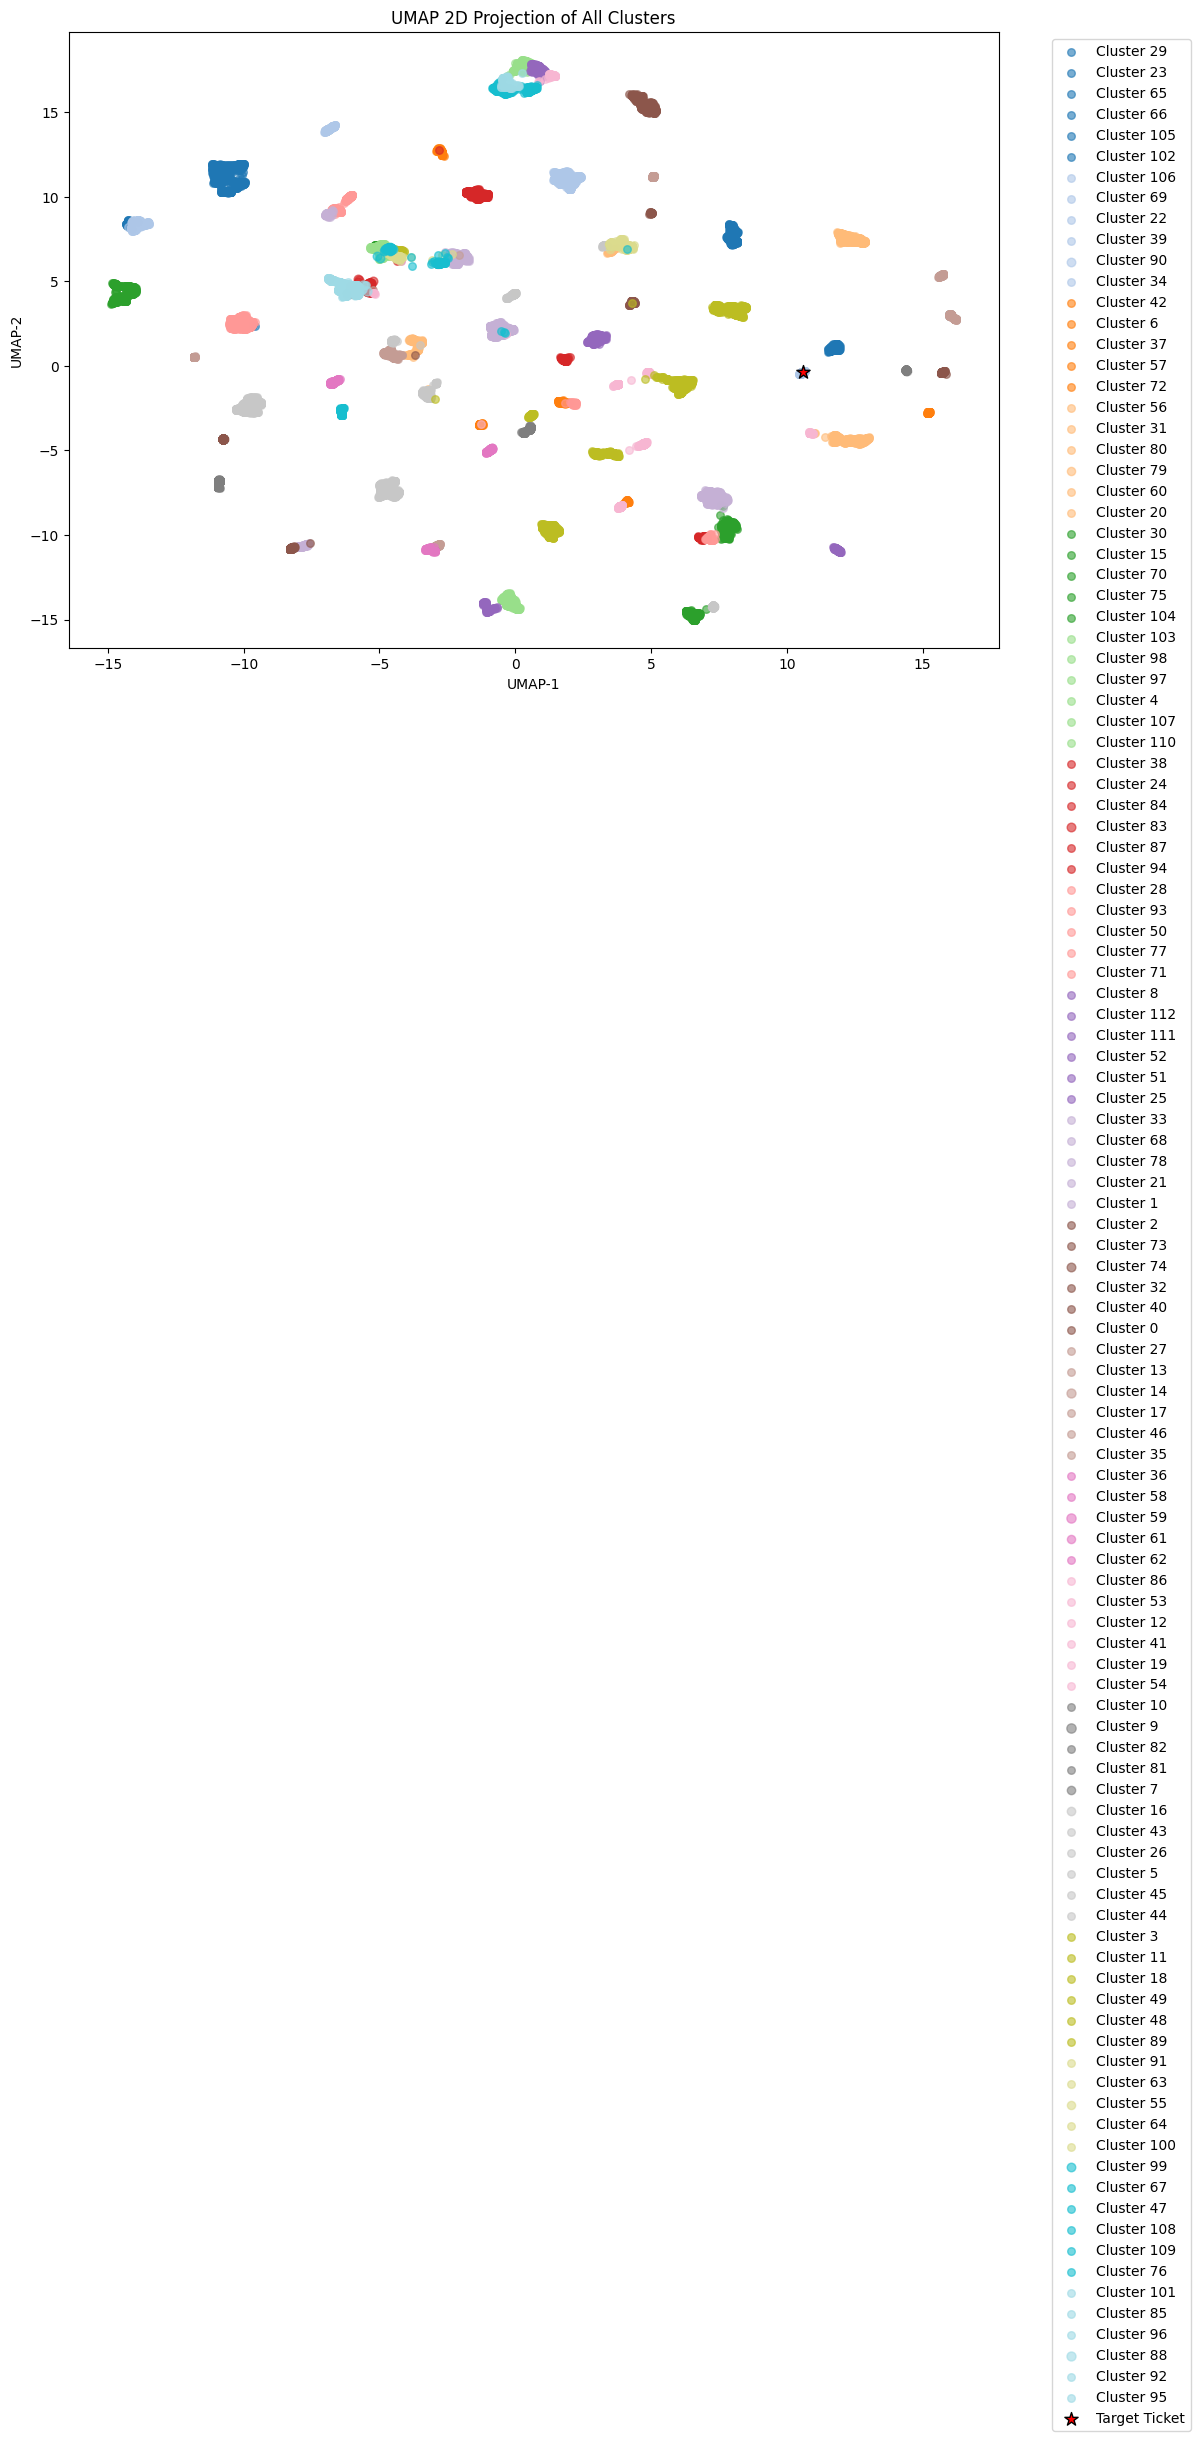

In [26]:
dgn.plot_all_clusters(ticket_id)

<div style="font-size:16px;"><strong>Diagnostic step 3:</strong></div>

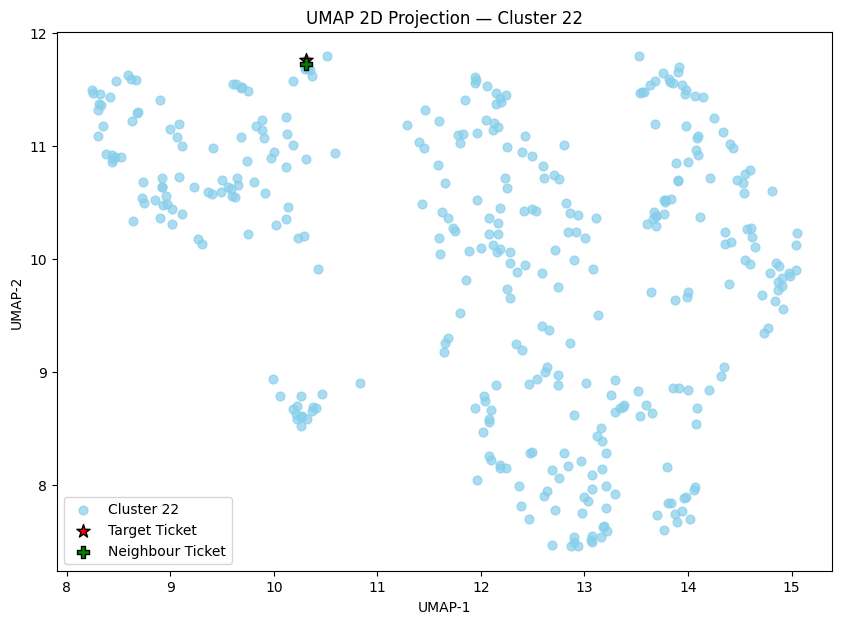

In [27]:
dgn.plot_cluster_projection(ticket_id, neighbour_id, cluster_id)